# Adversarial Auto Encoder

##### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from time import time
import os
os.chdir('C:/Users/Nicolas/Documents/Data/Faces')
import argparse
import math
import itertools
from sklearn.model_selection import train_test_split

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

##### Loading all file names

In [2]:
files = glob('combined/*.jpg')
files = np.random.permutation(files)

In [3]:
files[:5]

array(['combined\\35_1_1_20170116021348604.jpg.chip.jpg',
       'combined\\7_0_1_20170113161247843.jpg.chip.jpg',
       'combined\\57_0_0_20170113210319823.jpg.chip.jpg',
       'combined\\16_0_0_20170110231909175.jpg.chip.jpg',
       'combined\\30_1_3_20170104231929137.jpg.chip.jpg'], dtype='<U47')

##### Keeping all correctly formatted labels

In [4]:
np.unique([i[-34] for i in files], return_counts=True)

(array(['0', '1', '9', '_'], dtype='<U1'),
 array([12387, 11316,     1,     5], dtype=int64))

##### Removing problematic target names

In [5]:
faces = [i for i in files if (i[-34] in ('0', '1')) and len(i[-37:-35].strip('\\').strip('d'))  == 2 ]

In [6]:
y = [i[-34] for i in files if (i[-34] in ('0', '1')) and len(i[-37:-35].strip('\\').strip('d')) > 1 ]

In [7]:
sex = ['men', 'women']

In [8]:
assert len(y) == len(faces), 'The X and Y are not of the same length!'

#### This is the shape width/height

In [9]:
dim = 60

#### Cropping function

In [10]:
def crop(img):
    if img.shape[0]<img.shape[1]:
        x = img.shape[0]
        y = img.shape[1]
        crop_img = img[: , int(y/2-x/2):int(y/2+x/2)]
    else:
        x = img.shape[1]
        y = img.shape[0]
        crop_img = img[int(y/2-x/2):int(y/2+x/2) , :]

    return crop_img

##### Loading and cropping images

In [11]:
print('Scaling...', end='')
start = time()
x = []
num_to_load = int(len(faces)/5) # len(faces)  
for ix, file in enumerate(faces[:num_to_load]): 
    image = plt.imread(file, 'jpg')
    image = Image.fromarray(image).resize((dim, dim)).convert('L')
    image = crop(np.array(image))
    x.append(image)
print(f'\rDone. {int(time() - start)} seconds')
y = y[:num_to_load]

Done. 5 seconds


##### Turning the pictures into arrays

In [12]:
x = np.array(x, dtype=np.float32).reshape(-1, 1, 60, 60)
y = np.array(y, dtype=np.float32)
labels = y.copy()

##### Turning the targets into a 2D matrix

In [13]:
assert x.ndim == 4, 'The input is the wrong shape!'

In [14]:
yy, xx = y.nbytes, x.nbytes

In [15]:
print(f'The size of X is {xx:,} bytes and the size of Y is {yy:,} bytes.')

The size of X is 59,428,800 bytes and the size of Y is 16,508 bytes.


In [16]:
files, faces = None, None

##### Displaying the pictures

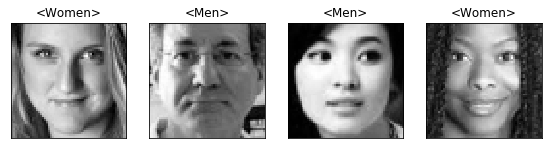

In [17]:
fig = plt.figure(figsize=(12, 12))
for i in range(1, 5):
    plt.subplot(1, 5, i)
    rand = np.random.randint(0, x.shape[0])
    ax = plt.imshow(x[rand][0, :, :], cmap='gray')
    plt.title('<{}>'.format(sex[int(labels[rand])].capitalize()))
    yticks = plt.xticks([])
    yticks = plt.yticks([])

In [18]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=2e-1)
# x, y = None, None

In [19]:
print('Scaling...', end='')
image_size = x.shape[1] * x.shape[1] 
x = x.astype('float32') / 255 
print('\rDone.     ')

Done.     


In [20]:
if torch.cuda.is_available():
    # x_train = torch.from_numpy(x_train) 
    # x_test = torch.from_numpy(x_test) 
    # y_train = torch.from_numpy(y_train) 
    # y_test = torch.from_numpy(y_test)
    x = torch.from_numpy(x) 
    y = torch.from_numpy(y)
    print('Tensors successfully flushed to CUDA.')
else:
    print('CUDA not available!')

Tensors successfully flushed to CUDA.


##### Making a dataset class

In [21]:
class Face():
    
    def __init__(self):
        self.len = x.shape[0]
        self.x = x
        self.y = y
        
    def __getitem__(self, index):
        return x[index], y[index].unsqueeze(0)
    
    def __len__(self):
        return self.len

##### Instantiating the class

In [22]:
train = Face()

##### Parsing the args

In [23]:
os.makedirs("images", exist_ok=True)

In [24]:
parser = argparse.ArgumentParser()

In [25]:
parser.add_argument("--n_epochs", type=int, default=25, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=32, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.005, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.3, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=3, help="dimensionality of the latent code")
parser.add_argument("--img_size", type=int, default=60, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=50, help="interval between image sampling")

_StoreAction(option_strings=['--sample_interval'], dest='sample_interval', nargs=None, const=None, default=1, type=<class 'int'>, choices=None, help='interval between image sampling', metavar=None)

In [26]:
# opt = parser.parse_args()
opt, unknown = parser.parse_known_args()

In [27]:
print(opt)

img_shape = (opt.channels, opt.img_size, opt.img_size)

Namespace(b1=0.3, b2=0.999, batch_size=32, channels=1, img_size=60, latent_dim=3, lr=0.005, n_cpu=8, n_epochs=25, sample_interval=1)


##### Reparametrization

In [28]:
cuda = True if torch.cuda.is_available() else False

In [29]:
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = Variable(Tensor(np.random.normal(0, 1, (mu.size(0), opt.latent_dim))))
    z = sampled_z * std + mu
    return z

##### Encoder

In [30]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.mu = nn.Linear(512, opt.latent_dim)
        self.logvar = nn.Linear(512, opt.latent_dim)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z

##### Encoder

In [31]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(opt.latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, int(np.prod(img_shape))),
            nn.Tanh(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], *img_shape)
        return img

##### Discriminator

In [32]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(opt.latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity

##### Create loss function

In [33]:
# Use binary cross-entropy loss
adversarial_loss = torch.nn.BCELoss()
pixelwise_loss = torch.nn.L1Loss()

##### Instatiate the classes

In [34]:
# Initialize generator and discriminator
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()

##### Send to cuda if possible

In [35]:
if cuda:
    encoder.cuda()
    decoder.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()

##### Make dir

In [36]:
# Configure data loader
os.makedirs("directory", exist_ok=True)
dataloader = torch.utils.data.DataLoader(train, batch_size=opt.batch_size,
    shuffle=True,
)

##### Make pics

In [37]:
# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=opt.lr, betas=(opt.b1, opt.b2)
)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


def sample_image(n_row, batches_done):
    """Saves a grid of generated digits"""
    # Sample noise
    z = Variable(Tensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    gen_imgs = decoder(z)
    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)

##### Train the model

In [38]:
for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        encoded_imgs = encoder(real_imgs)
        decoded_imgs = decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss = 0.001 * adversarial_loss(discriminator(encoded_imgs), valid) + 0.999 * pixelwise_loss(
            decoded_imgs, real_imgs
        )

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()
        
        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            sample_image(n_row=5, batches_done=batches_done)
            
    print(
        "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
    )

        

[Epoch 0/25] [Batch 128/129] [D loss: 0.530735] [G loss: 0.227785]
[Epoch 1/25] [Batch 128/129] [D loss: 0.536842] [G loss: 0.189113]
[Epoch 2/25] [Batch 128/129] [D loss: 0.625455] [G loss: 0.176759]
[Epoch 3/25] [Batch 128/129] [D loss: 0.530406] [G loss: 0.189388]
[Epoch 4/25] [Batch 128/129] [D loss: 0.618144] [G loss: 0.180223]
[Epoch 5/25] [Batch 128/129] [D loss: 0.616816] [G loss: 0.163058]
[Epoch 6/25] [Batch 128/129] [D loss: 0.313410] [G loss: 0.199729]
[Epoch 7/25] [Batch 128/129] [D loss: 0.719056] [G loss: 0.186529]
[Epoch 8/25] [Batch 128/129] [D loss: 0.675545] [G loss: 0.175951]
[Epoch 9/25] [Batch 128/129] [D loss: 0.317447] [G loss: 0.186320]
[Epoch 10/25] [Batch 128/129] [D loss: 0.579522] [G loss: 0.165260]
[Epoch 11/25] [Batch 128/129] [D loss: 0.442489] [G loss: 0.187621]
[Epoch 12/25] [Batch 128/129] [D loss: 0.441387] [G loss: 0.142490]
[Epoch 13/25] [Batch 128/129] [D loss: 0.722367] [G loss: 0.113072]
[Epoch 14/25] [Batch 128/129] [D loss: 0.573351] [G loss: 

Look at generated faces

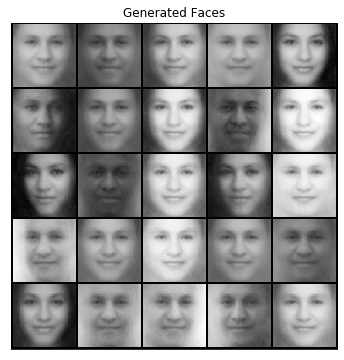

In [48]:
picture = plt.imread(r'C:\Users\Nicolas\Documents\Data\faces\images/3224.png')
plt.figure(figsize=(6, 6))
plt.imshow(picture)
plt.xticks([]), plt.yticks([])
plt.title('Generated Faces')
plt.show()